# Homework 1 Report

Since I have already implemented a Vigenere cipher attack strategy for my cryptography class, that is what I elected to use for this assignment.

Please let me know if you prefer a classical report without the code snippets that I used. I prefer to include both the code I used and a discussion of its results, but this is not an opinion everyone holds.

## Summary of Vigenere Attack Strategy

The attack strategy I implemented is similar to what we discussed in class, but not as sophisticated, I believe. It works by

* Compute the probable key length $k$.
  * Rotate the ciphertext some number of rotations greater than the believed key length.
  * Count the number of coincidences for each rotation.
  * The probable key length is the number of rotations corresponding to the highest coincidence.
* From $i = 0\dots k$, build the probable key.
  * The $i$th letter of the probable key is $j$th letter corresponding to the maximum dot product of the ciphertext symbol frequency vector and the English letter frequency vector rotated $j$ places.

In code, we can count the number of coincidences between a ciphertext and its rotated version with
```python
@staticmethod
def coincidences(original, rotation):
    """Compares a rotated ciphertext with the original ciphertext and counts how many
    character coincidences there are for the given rotation."""

    return sum(o == r for o, r in zip(original, rotation))
```
Then we can count the number of coincidences resulting from all rotations of the given ciphertext with
```python
@classmethod
def compare_rotations(cls, text, num_rotations=15):
    """Counts the coincidences of all rotations of the given text.

    Takes in an optional tweaking parameter `num_rotations` that sets the number of
    rotations to use when counting coincidences in order to determine the probable key
    length. The num_rotations parameter should be bigger than the believed key length.

    Returns a dictionary of rotation : coincidences pairs"""

    return {
        r: cls.coincidences(text, rotate(text, -r))
        for r in range(1, min(num_rotations, len(text)))
    }
```
and compute the probable key length of the ciphertext under consideration with
```python
def probable_key_length(self, num_rotations=15):
    """Computes the probable key length by comparing rotations of the ciphertext to the
    original ciphertext and counting the coincidences. The maximum number of coincidences
    is the probable key length.

    Takes in an optional tweaking parameter `num_rotations` that sets the number of
    rotations to use when counting coincidences in order to determine the probable key
    length. The num_rotations parameter should be bigger than the believed key length."""
    max_coincidence, _ = max_pair(self.compare_rotations(self.ciphertext, num_rotations))
    return max_coincidence
```
Finally, we can compute the probable key with the above dot product approach with
```python
def probable_key(self, num_rotations=15):
    """Attempts to find the key by performing a frequency analysis on every
    `probable_key_length`th character and performing the second method for finding the
    key as described in the textbook.

    Assume the key length is known to be n and A_0 is the known English Letter Frequenceies:

    for i in 1..n:
        * Compute the frequencies of the filtered letters in positions i mod n
        * for j in 1..25 compute W dot A_j where A_j is A_0 rotated right j positions
        * k_i = the j associated with the maximum dot product in the previous step
    The key is then probably {k_1, ..., k_n}."""
    def proportion_vector(proportions):
        """Convert a `SymbolFrequencies.proportions` to a numpy vector."""
        vec = []
        for c in string.ascii_lowercase:
            try:
                vec.append(proportions[c])
            except KeyError:
                vec.append(0)
        return numpy.array(vec)

    # Convert ENGLISH_LETTER_FREQUENCIES.values() to an array rather than a dict.view() object
    A0 = numpy.array(
        [SymbolFrequencies.ENGLISH_LETTER_FREQUENCIES[l] for l in string.ascii_lowercase]
    )

    key_length = self.probable_key_length(num_rotations)
    key = []
    for i in range(0, key_length):
        # Filter the ciphertext and calculate the symbol frequencies
        table = SymbolFrequencies(self.ciphertext[i::key_length])
        W = proportion_vector(table.proportions)
        # numpy.roll is equivalent to crypto.utilities.rotate, but returns a numpy.ndarray
        # Find the alphabet index associated with the maximum dot product
        ki, _ = max_pair({j: numpy.dot(W, numpy.roll(A0, j)) for j in range(0, 26)})
        key.append(ki)

    return "".join(map(char_mapping, key))
```

The implementation of the attack may be found in full [here](https://github.com/Notgnoshi/cryptography/blob/master/crypto/attacks/vigenere.py).

## Vigenere Attack on Given Ciphertexts

After pasting the contents of the lone `.docx` ciphertext file into a `.txt` file with the same name, I performed the above Vigenere attack on each ciphertext. I chose the Vigenere attack because
* It's more complicated than a simpel letter frequency analysis strategy
* We talked more about the Vigenere attack than any other in class
* The Vigenere cipher seemed the most likely that students would use

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import json
import string
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from crypto.attacks import VigenereAttack
from crypto.classical import VigenereCipher
from crypto.math import SymbolFrequencies
from crypto.utilities import preprocess

sns.set()

After opening each files before running my attack, I noticed that a great many submissions included spaces, punctuation, upper and lowercase numbers, and in one instance non-unicode characters. This forced me to preprocess the contents of each file, converting everything to lowercase, and filtering out any non-alphabetic characters. Usually it is bad form to modify a given ciphertext before performing cryptanalysis, but in this case it was acceptable due to the constraints of the problem. Since it was obvious for some ciphertexts that spaces and punctuation were left untouched, it made sense to strip out the illegal symbols even though the classical Vigenere cipher usually operates on each letter.

I simply ran the `VigenereAttack` discussed above on each of the given ciphertexts and collected the results into a JSON file, containing the ciphertext filename, the ciphertext, probable key length, probable key, and the deciphered plaintext using the calculated key.

In [2]:
files = glob('ciphertext/*.txt')
ciphertexts = [{'filename': f} for f in files]

for c in ciphertexts:
    # Some files have non-utf-8 characters, so replace undecodable characters with something else.
    with open(c['filename'], 'r', errors='ignore') as f:
        # A large number of submissions did not remove punctuation or convert to a single case.
        c['ciphertext'] = ''.join(preprocess(f.read()))
        attack = VigenereAttack(c['ciphertext'])
        c['key_length'] = attack.probable_key_length()
        c['key'] = attack.probable_key()
        cipher = VigenereCipher(c['key'])
        c['plaintext'] = cipher.decrypt(c['ciphertext'])

with open('HW1-results-Austin-Gill.json', 'w') as f:
    json.dump(ciphertexts, f)

After visual inspection of the deciphered plaintext, I found that the Vigenere attack was successful on all but the seven files below. As a check on my above assumption that stripping out nonalphabetic characters was acceptable, I checked the contents of each file. What I found was that only two of the outlier files contained ciphertext that I was unable to decrypt. The rest followed the rules given in the assignment, and yet I was still unable to decipher them.

Of note is the file that contained non-unicode symbols. I am unsure how this could have happened, but perhaps my strategy of ignoring the undecodeable characters was incorrect.

In [3]:
failures = [
    'ciphertext/126289-718150 - cipher.txt', # followed rules
    'ciphertext/126304-718150 - cipher.txt', # unicode decode errors
    'ciphertext/142884-718150 - cipher.txt', # followed rules
    'ciphertext/144862-718150 - cipher.txt', # Spaces and punctuation
    'ciphertext/158105-718150 - cipher.txt', # followed rules
    'ciphertext/158517-718150 - cipher.txt', # followed rules
    'ciphertext/176145-718150 - cipher.txt', # followed rules
]

I believe that my Vigenere attack should have been able to decipher any ciphertexts encrypted with a Caesar cipher. But I still wanted to plot the letter frequency histograms and compare them to that of the English language to get a sense of what kind of ciphers I failed to decrypt.

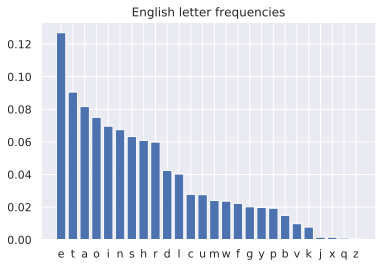

In [4]:
data = list(SymbolFrequencies.ENGLISH_LETTER_FREQUENCIES.items())
data.sort(key=itemgetter(1), reverse=True)
plt.bar(*zip(*data))
plt.title('English letter frequencies')

plt.show()

What we see is that only two of the ciphertexts I failed to encrypt have similar profiles to that of the English language. This does not necessarily indicate that a Caesar cipher was used however. The same profiles could appear even with a random mapping, rather than an algorithmic rotation like the Caesar cipher.

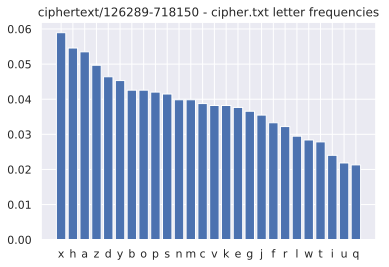

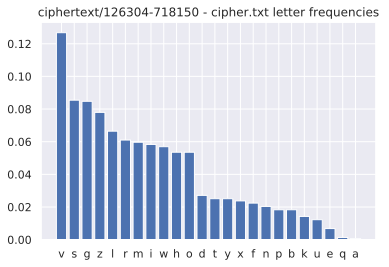

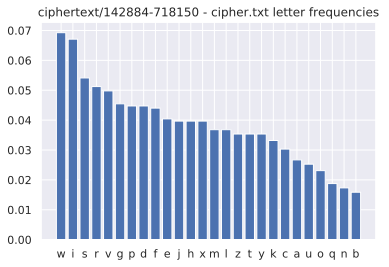

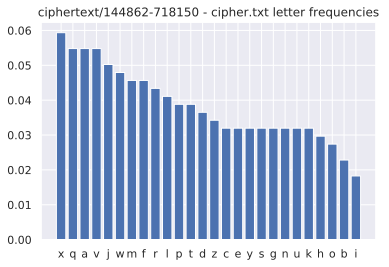

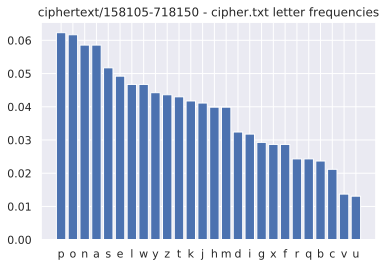

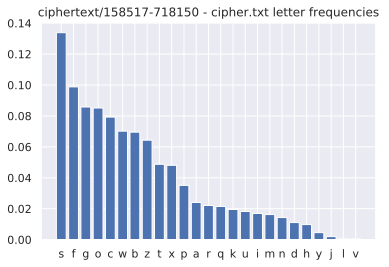

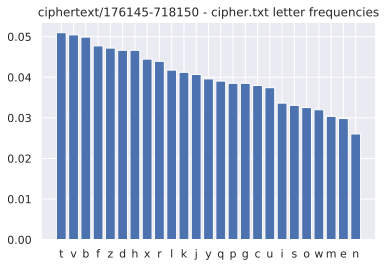

In [5]:
for fail in failures:
    with open(fail, 'r', errors='ignore') as f:
        # Remove newlines, etc.
        ciphertext = ''.join(preprocess(f.read()))

    freq_table = SymbolFrequencies(ciphertext)
    data = list(freq_table.proportions.items())
    data.sort(key=itemgetter(1), reverse=True)

    plt.bar(*zip(*data))
    plt.title(f'{fail} letter frequencies')
    plt.show()

So out of curiosity I attempted to rebuild the random maps based on the histograms and attempt to decipher the ciphertext.

In [6]:
file1 = 'ciphertext/126304-718150 - cipher.txt'
file2 = 'ciphertext/158517-718150 - cipher.txt'

with open(file1, 'r', errors='ignore') as f1, open(file2, 'r') as f2:
    # Remove newlines, etc.
    c1 = ''.join(preprocess(f1.read()))
    c2 = ''.join(preprocess(f2.read()))

    freq1 = SymbolFrequencies(c1)
    prop1 = list(freq1.proportions.items())
    prop1.sort(key=itemgetter(1), reverse=True)
    
    freq2 = SymbolFrequencies(c2)
    prop2 = list(freq2.proportions.items())
    prop2.sort(key=itemgetter(1), reverse=True)
    
mapping = list(SymbolFrequencies.ENGLISH_LETTER_FREQUENCIES.items())
mapping.sort(key=itemgetter(1), reverse=True)
mapping = ''.join(t[0] for t in mapping)

In [7]:
print(mapping)
map1 = ''.join(t[0] for t in prop1) + '??'
print(map1)
map2 = ''.join(t[0] for t in prop2) + '?'
print(map2)
trans1 = str.maketrans(map1, mapping)
trans2 = str.maketrans(map2, mapping)

etaoinshrdlcumwfgypbvkjxqz
vsgzlrmiwhodtyxfnpbkueqa??
sfgocwbztxparqkuimndhyjlv?


In [8]:
plain1 = c1.translate(trans1)
plain2 = c2.translate(trans2)

In [9]:
print(plain1)

atecnsrcodoaihhesaivrohyseddogisuateufdapaheedategiiscodoutidalpuolleisaidderfbiswlifrpdeodatehiorcodohnmmisivgiislnutaikehatebfhblegiihosratetnutcopgoswogehnrnsuhnrnsuhnrnsuatetnutcopgoswogehnrnsufbaiateilrnssriihterovheswtwiwyertoaistndviheteoromfswtivloweoatndwtnsowioaivatewloheakelkeaosrmheewtedivmhicsriedynsatepvnaaercnatsekehochnsyletndmiiadcehefbaiateatnutosrtehirecnatojecelleracnsyletndbndailmfaadoacnsyletndhobnehtnlaoacnsylefsrehatejecellerdypikehatewimmledtewloaaeherosrwlodternsaterohynsspohrteaobbercnattndctnbisatedtfaaehdmfaollcodliwyerosrmohhertectndaleroafseaiatecnsricosrctidtiflrmeconansuatehemfaatelosrlihrdmlowyeperrofutaehmeddatelosrlihrdrofutaehblonansuorohyherlikeysiansaitehlisumlowytonhosrrohynsaterohyilrnsspohrodaomlecnwyeawheoyercteheangateidalehlndaesertndvowecodctnaeosrbeoyertndepedcehetillicdivgorseddtndtonhlnyegiflrptopmfatelikeratelosrlihrdrofutaehatelosrlihrdherlnbberrofutaehrfgmodoriutelndaeserosrteteohratehimmehdopiseynddgpmisspdceeateohangovaehobhnxeaisnu

In [10]:
print(plain2)

dnttdedewnacyaihnaeeaiceevnlehmetrotyigrovetreopndntytideoshamnehmehgcpesohlbsibistnihaohlnsemifhnxeyigsabemnodleansetideoshopigttreoatsidopeaioatrebrndiaibresaonlreaesvearnausnehlwrifsohtarnausnehlawnareanbsibiaetiteomryigaiceuomtaopigttrenhatsgcehtwntrtrnatseotnaetreseoseaevesodseoaihauistrnatseotnaeunsathiihenhtrnasefnihroamicbdetekhiwdelfeiutrehipdeoatsidopeohitresseoaihnatrottreseoseessisanhtreoatsidopetseotnaeatrotnroveaeehohlaiceiutrecbseaehtcotesnodtiilnuunmgdtuisotehyeosidltighlesatohltrnatseotnaenalnvnlelnhtiunvebostaohlnawsnttehmdeosdyohlnhbdonhehfdnarpemogaeyigsdotnhnaatnddhitfiilehigfrcydnttdeaihpgttreuomtaosetreaocenhehfdnaroafseekwoatitrefseekaosopnmtitreosoparepsewtitreqewaohldotnhtitresicohawrideosheltrecunsatusicitreslnvesaedohfgofeaohlsewsitetrecnhdotnhohloafilwnddaoddiutreaeuomtarovepeehmicbdetedydeoshelohltogfrtnhoddtreaedohfgofeapgtpylnuuesehtcetrilacgmroaoddsioladeoltisicehiwnoakevesybesaihwriseolaisreosatrnadnttdetseotnaetiejmgaecymsgleelntnhfohlcyejmeaanvegaeiu

Neither of the of the translated strings make sense, although they do visually look less random than their corresponding ciphertexts. In the first at least, there seem to be fragments of English text, but this might be a coincidence.

It makes sense that these straight mappings don't make sense, because that would require that the ciphertext symbol frequencies *exactly* matched up with the English letter frequencies, *and in the same order*. However, this is a strict requirement, and is unlikely to be met by chunks of ciphertext so small.

Since I have already met the requirements for this portion of the homework, I did not pursure this any farther.

## Vigenere Attack Results

I'd prefer to not include large snippets of ciphertext and plaintext in a report-style document, but here are three of the successfully decrypted ciphertexts in a prettified version of the JSON file also included.

```json
[{
    "filename": "ciphertext/157414-718150 - cipher.txt",
    "ciphertext": "dxtvsladpyrtcszpvsmetdldosfukhvolaywxughximotuejzjpgzomnxhupbydzgfbzdybznqygtvwytovwvughximlqdreyjpordplilupwudvgnmdpqfnycaokamdtuepmohlrsjpbsvydqtqkkqnpfglvaleubbewwzzcjdhiymeizvyqilqjuwzcwjtvbpykysydojskjtvgpltiafbeyehgnwzslutxwekgavzdfrpvipzostpkwesklpdiscplznedxpfuubpclfzpjslytmdhstpkhpfeimchwpfbyebozigtjlryeownpvrpfqerydpkzalvwvdmexsrlbpaqfpmkchzombjapvlhzztmwiymzaceghxappasmjnerouymxxhffwtzouyatiszpdszqylketlhckttsozktcyrwsjdhjkwpxmfxytehswwcxfptnyoxtaceasozbupwjvtzgwzlqdldrpyfpmgpxyxdjtqyxeipxylpwbqdcgfebkohdlznxlneseyxrsixrgylleclyuqdxmglvybxowmitspzwczgujwyhwdfkjoxozifiwvcehpguswcxfepzhpkkulpgagtxlzoawbliwipvyehyzmnxdyfwtzouympjxhrsqeqastlesetkjfukekpelrfbitqzvknpwpldsfsokieplazxfcrokmyikhydyyfasxlfmvzpvtfohlphwefxjxrrsqepfvxstpvzsimdjhxqxzvzicdiwedsvekkymdhgzpdxtqmzbcpftpsdjraumtvzozbxzrjdpznghrydydihtwvzbddrfvzlzdxxgsohpvyvupizvyqmplxkiysagoydeouvsrdgqhrejranwycsplvbrkuzbmjkgpbitdoublujntneqqunpzhlvlsdedlyitsgsyywsryaqqnghcoiphouoewaarchfqtpvrizezewsbubzstsqhrejranwycsplvbrkuzbmjkgpbilqoudthaowoclqysmpeaarsdjrayjpsouziefjuuvlrsywqxzvzicdiwedsqtqzhncpaqzpdzjnvaexsvydqqugplzufbrredwcowjdmtzxdlfgstrwgfelkdwkyatuqbfbulorhtzcwctmafszomawgapkdofgsthtjrekbvltnihpqvoydentvehwsgtwjzvgfqwaknjsjlqedijigqliilquappgvnjdeqltkgzjkujsdrdchgtadopmexltnnzgqbfbbzykvslnlnvoeypkaivtgaxojlnktmzclnvoeypkptwqwtzxutqgkijdjghyizqkllwtkfeyilbotwosknynuygyicexdymoiexsittcynhkodoudtjawncxyyjzoieaaspsizngfalnsseohxhoaaydtreducwuimdpxrerqyvuyzjisxpydxhzhspdfzpdqvhslwyisxpydxhostmtybyoyydjhgzgljz",
    "key_length": 12,
    "key": "kqldghilpsnl",
    "plaintext": "thismessageiscompletelysecureandwillneverbedecryptedthecipheriswaytoogoodandnoonewilleverbeabletotellwhatthemessagesayscompletesecrecywillbemaintainedicantalkaboutthemostsecretthingsandnoonewilleverknowwhatisaiditisquiteagoodthingthatnooneelsewilleverhaveacluewhatthecontentsofthismessagearecybersecurityisaverygoodthingandthismessageiscompletelysecurethequickbrownfoxjumpsoverthelazydogloremipsumdolorsitametconsecteturadipiscingelitseddoeiusmodtemporincididuntutlaboreetdoloremagnaaliquautenimadminimveniamquisnostrudexercitationullamcolaborisnisiutaliquipexeacommodoconsequatduisauteiruredolorinreprehenderitinvoluptatevelitessecillumdoloreeufugiatnullapariaturexcepteursintoccaecatcupidatatnonproidentsuntinculpaquiofficiadeseruntmollitanimidestlaborumghostbustersiftheressomethingstrangeinyouneighborhoodwhoyougonnacallghostbustersiftheressomethingweirdanditdontlookgoodwhoyougonnacallghostbustersiaintafraidofnoghostiaintafraidofnoghostifyoureseeingthingsrunningthroughyourheadwhoyougonnacallghostbustersaninvisiblemansleepinginyourbedwhoyougonnacallghostbustersiaintafraidofnoghostiaintafraidofnoghostwhoyougonnacallghostbustersifyoureallalonepickupthephoneandcallweretalkingawayidontknowwhatimtosayillsayitanywaytodaysanotherdaytofindyoushyingawayillbecomingforyourloveokaytakeonmetakeonmetakemeontakeonmeillbegoneinadayortwosoneedlesstosayimoddsandendsbutillbestumblingawayslowlylearningthatlifeisokaysayaftermeitsnobettertobesafethansorrytakeonmetakeonmetakemeontakeonmeillbegoneinadayortwo"
},
{
    "filename": "ciphertext/135782-718150 - cipher.txt",
    "ciphertext": "rusfmpjafhsksezpjbsempzbqdkefbisgkmittdhdveusdsqjhhoelcempjbqlkuaptiebwounspzbitzgwphezhdvqrddadxeqpzbsomownkemywpefzjqlvuroaqjimcgkjhdoaaulhjwpqrdigoudhnwxddhpkketzoacmegwnbdtgwvyygdhwzjinjkyufnnwlhbhcueeibakqemzgwfdotnzfitnnqqxeewuqyscaelsrzyqeqsmanbhbdafbqsxwfaeuqbgrddhjycqtgajpqrfqwaqbnqlblequleynfswtqgdzszyvhhoxhwdknbhcziwaupqakpyomswsultnueudengjurzogcwrdwlmhofnwpiiuaueqnfallfeqegaioenwqhemyzjunsolfbllkkqqmdnazqnrwdfleskvxocdnlxynkuleussqvbdtrszlqrddwouhzrwlfeqwlbtumzwoiolaulcmnjspiulllfenrwtlktvdgtuaqasktwgwltusswfavoqkmqefsdwqkrlkaiefsdwfddtoloyaknwseltpaldamzleugqasqteonwpiinjsjurhysxtaopwaqndswzenniqxjhbafqkrxauldoluyrydhjylkrenwbcaqgwqmisdjbwukwlfenrpgmhosauqxezhleqncoscutxwfavahnulcpdpaqyomaemewdnakwwnncbhsveleknhkfjevdiwkjshjnbithjyfdsbewksezjvfdfqwkqhubpmouamzwakczpaldakefpjisqlfenrhahuunbapjrdjyqxemefdeuqoqpjelkxmhilwjvqncowzencwjvudtysqyomwfaithpueynfpgdutgajxiobesiiaealvdeswfaqlkkxqxirhwajotjjflakavmhorlwoytxwfajhdnapuoewtoeacwfatedleftdkauiqsrefqxerafputgwlfvynqolhkdzzxhdxkmzeukzuiymapzbbaczwoefrquzusrwfadosanbhynjwtqshjuikddzakjhhohoesoajfjysdwouwzosietlkjbmoqglltozjvpeimnwpfomowqetgakqqimkxpbauajvqncowdhefwlfenzjvqxeqasiytxkxoqchwdaysbnajynzpaldtgaufliknadxtrigsumdjlketnjdvepdjwadevzglhsekjxvrhyskqmdnazqnrelxbsnkhbdecqhqxeehgltgzpwpefnlhlhttjaqofnnolcemwfaqmdnazqnrsaqxdhosyylhpabiamzddrtziwoyczjkxddnpzbhsskexaesdwfhovjuiqilollvukhsktepqsisiserbdsgehxddzhleeufdvficqeefdasegkhelwakudzlwodibegrifnnubynnqjpechalvqncygkjimqwpjosdaptaxwfaqlsdgrwhsdwouaqauldtqknbhshakxrotpzlmtnxwpjemomougdjmfdedmmxbisugcepokjqknhpqqxeqakyuemwliuarpjlkggwyouelafqqmnjyqxenrwomhdhefdglwblhisugcqmdnazqnrpzxjotnulknsnqfissngkwerpoeundrwoobnzqpjrdwlbtfzejiowgafmuoohwxheiqvdudnjleumdnaqiamzleucnjlbdtnbleuiqyzxhabpwoqncjgqjhdygiernbleuiqocfdoqpzbmaxeftxibdleuyvkjpxiocgaersdwfhlzolkqmdoskttgwlzenrafpkssdwkuxsafaudaaqlddnqjyercajpqncbjlctgaooucjwybefvkjitwznafmeaqaijaokkqmaqswyqrbdaqucsqjbiyrpwjefzhdfqnbakxddhjkqyttpaldsskmkteqsjfjeenwbtolwfaepokkb",
    "key_length": 12,
    "key": "qazwsxqazwsx",
    "plaintext": "butjustaglanceatrecentheadlinesshouldtellyouthatthismomentreallyisdifferentthestakesreallyarehighertheconsequencesofanyofussittingonthesidelinesaremoredireanditsnotasifwehaventhadbigelectionsbeforeorbigchoicestomakeinourhistorythefactisdemocracyhasneverbeeneasyandourfoundingfathersarguedabouteverythingwewagedacivilwarweovercamedepressionwevelurchedfromerasofgreatprogressivechangetoperiodsofretrenchmentstillmostamericansalivetodaycertainlythestudentswhoareherehaveoperatedundersomecommonassumptionsaboutwhoweareandwhatwestandforoutoftheturmoiloftheindustrialrevolutionandthegreatdepressionamericaadaptedaneweconomyathcenturyeconomyguidingourfreemarketwithregulationstoprotecthealthandsafetyandfaircompetitionempoweringworkerswithunionmovementsinvestinginscienceandinfrastructureandeducationalinstitutionslikeuofistrengtheningoursystemofprimaryandsecondaryeducationandstitchingtogetherasocialsafetynetandallofthisledtounrivaledprosperityandtheriseofabroadanddeepmiddleclassinthesensethatifyouworkedhardyoucouldclimbtheladderofsuccessandnoteveryonewasincludedinthisprosperitytherewasalotmoreworktodoandsoinresponsetothestainofslaveryandsegregationandtherealityofracialdiscriminationthecivilrightsmovementnotonlyopenednewdoorsforafricanamericansitalsoopenedupthefloodgatesofopportunityforwomenandamericanswithdisabilitiesandlgbtamericansandotherstomaketheirownclaimstofullandequalcitizenshipandalthoughdiscriminationremainedaperniciousforceinoursocietyandcontinuestothisdayandalthoughtherearecontroversiesabouthowtobestensuregenuineequalityofopportunitytheresbeenatleastroughagreementamongtheoverwhelmingmajorityofamericansthatourcountryisstrongestwheneverybodystreatedfairlywhenpeoplearejudgedonthemeritsandthecontentoftheircharacterandnotthecoloroftheirskinorthewayinwhichtheyworshipgodortheirlastnamesandthatconsensusthenextendedbeyondourbordersandfromthewreckageofworldwariiwebuiltapostwarwebarchitecturesystemofalliancesandinstitutionstounderwritefreedomandoppose"
},
{
    "filename": "ciphertext/177688-718150 - cipher.txt",
    "ciphertext": "ledydnyigswxneelthkwvtiptgufliifhbdpiqdjefstcdtjzzoprcdpttxzzowhstsoexilnwkskttseudbspsmwaewvdirlhxkeccpyycrixkeclfllhrtxkeccifgeqpxxnraizyzhfexvphmtpigcnitsijcfmyslihpehrlijomtoqemwiyuxhnslredojiskxnrwusiyvogsszjdzhjlrxctcimtamrblxdpsmzamhgtcdpgpyiqlqwdcevjyywhjxgysyoeyvdbwuocehpliysknhpvplhhfcpproiwplcffxptzvbyxhhgmgojiszzgljbaikeutirvsotrjojyaeqritadeoeyzhfrnofrhniyszxxnwswpyzhfrwoaigffgkwesegisjgswvxgayhglnlhfxkeccjypiqhhgayhfijprfxgegisjnidqatrzjnzleogxkeccdzlvxdmeowmutwmdbxkecctfjiugmprpzfcswxdktmppflxiusotrjwbthxdbwhiyrfccrwvxwidxpcssicngsaidtywowotdelfcysqofdtpsgoowwgnhpprepxmqoljnmibxnlhstgtsmtlpiumlbawpteukhwgpvlwuniwpwvprprbebmqyhutsistpiughubwspomtlzetdmcbwfxkcltgprfcupvogsextfcivvghihlxjyaprfrpnomoelmxaiwtsizniyorutczqfebipcftneesjgevhxgszjbqlefhbdnzjboixwvbckzjusyiqretsdgsfypwwxhvtwjeyhemmwetrilvmwogiszjpyygrfgtrzjusyhrhhcsnesnypbrbhttrhfcwkouaetrilvmwogiszjtzgirhatrnssyyvrtmweosusiaifxfupruebilffxsfreplwwogsiyktsiahoztrelfjuvhhhziwppyyeqcmweclphziujxctelftlldhktddsvcjsvhngiyktzovlatviyiedypiwfeocxbywiwvxsewyttirwvtiwplbgywraxertzjwykhridstxjzhmqhatuymwplwhoktcsemwyrjswqyeljdjslbmdfaempfmjvmductmlhiwwlplzrfwswssvziyxipavhomtngimzjmquvdsxmdouvnwgducscdwyuwmniyemwnllgopserfdmxksktidrpscrwhaptsimaqmozvdmpjszgiogxlhpvfeiwdjxjsqvpxiyugxavpwjecwxdmdudmudvihblpioxilnevhkdnzqztmekifqltrhlhhlabvheeeougkokpceismomorbcgpbqplmhbvttzqzxcrghatrpmtayvkoihnzffeniurxboywucuxlcgdfelfqipomhuhfqbywsqqxxtdxilhxkwlsidxbynmpoztoqsvcnmqmpdrwhuzgilhncdpvtnivhghjrcitairvwuxltxzeihhoebocilthhomtcdnsnauwvwhcaeimjqmwvhcelrpebiuogstztspmiujxpnogiplmvvmwaetbwyfoixsoexipiromadmpafgyiyskznzaonuvogtvaywqpygkomrocrfwfyqwotrdmuj",
    "key_length": 11,
    "key": "palebluedot",
    "plaintext": "wesucceededintakingthatpicturefromdeepspaceandifyoulookatityouseeadotthatsherethatshomethatsusoniteveryoneyoueverheardofeveryhumanbeingwhoeverlivedlivedouttheirlivestheaggregateofallourjoysandsufferingsthousandsofconfidentreligionsideologiesandeconomicdoctrineseveryhunterandforagereveryheroandcowardeverycreatoranddestroyerofcivilizationseverykingandpeasanteveryyoungcoupleinloveeveryhopefulchildeverymotherandfathereveryinventorandexplorereveryteacherofmoralseverycorruptpoliticianeverysuperstareverysupremeleadereverysaintandsinnerinthehistoryofourspecieslivedthereonamoteofdustsuspendedinasunbeamtheearthisaverysmallstageinavastcosmicarenathinkoftheriversofbloodspilledbyallthosegeneralsandemperorssothatingloryandintriumphtheycouldbecomethemomentarymastersofafractionofadotthinkoftheendlesscrueltiesvisitedbytheinhabitantsofonecornerofthedotonscarcelydistinguishableinhabitantsofsomeothercornerofthedothowfrequenttheirmisunderstandingshoweagertheyaretokilloneanotherhowferventtheirhatredsourposturingsourimaginedselfimportancethedelusionthatwehavesomeprivilegedpositionintheuniversearechallengedbythispointofpalelightourplanetisalonelyspeckinthegreatenvelopingcosmicdarkinourobscurityinallthisvastnessthereisnohintthathelpwillcomefromelsewheretosaveusfromourselvesitisuptousitsbeensaidthatastronomyisahumblingandimightaddacharacterbuildingexperiencetomymindthereisperhapsnobetterdemonstrationofthefollyofhumanconceitsthanthisdistantimageofourtinyworldtomeitunderscoresourresponsibilitytodealmorekindlyandcompassionatelywithoneanotherandtopreserveandcherishthatpalebluedottheonlyhomeweveeverknowncarlsaganspeechatcornelluniversity"
}]
```
The rest of the results, including the failed decryptions are included in the `HW1-results-Austin-Gill.json` file also submitted.

## CIA Violations

1. Jim copying Bob's homework is a violation of the usual confidentiality homework is treated with.
2. My current understanding is that in order for it to be counted as a violation, it must be a violation of Addison-Wesley's security policy. I don't believe that a company would cover domain squatting (something outside their control) in their security policy, unless related to renewing the domain from the registrar in a timely manner.

   If Eve was able to purchase the domain for herself if she noticed that Addison-Wesley failed to renew their domain name from their registrar, this definitely would be an availability violation, as Eve is denying Addison-Wesley the ability to host their site online at a domain advertised on a large amount of existing print and electronic media.
   
   This could also count as a violation of both confidentiality and integrity if Eve is able to replicate Addison-Wesley's actual website and host the impostor site on her new domain.
   
   If this is not Addison-Wesley's usual site, it might still be a confidentiality and integrity violation if their security policy mandates purchasing a large number of related domain names (this is a policy many companies have).
3. This is an availability violation, and possibly an integrity violation if the crash causes disk corruption from an unsafe shutdown.
4. This is an integrity violation.
5. This is an availability violation, because Eve is denying Jim the use of his credit card. It may also be a confidentiality violation, depending on the manner in which she obtained his card number.

## SHA-256 Document Hash

I computed the hash of this file (not its contents) before and after changing this letter: "x" from uppercase to lowercase. Because this is a Jupyter notebook (that was converted to a Docx *after* typing up the entire report), I removed all code output, including plots, before calculating the hash.

The hashses from the [http://www.fileformat.info/tool/hash.htm](http://www.fileformat.info/tool/hash.htm) website before and after respectively are

* Before `0d10d7e7260258f83f94101098ef5b6e63a9b664ca63ca026667a9c1e3ddfba4`
* After `eb29d96f5570c54bc474f26a6c280c1b44f491077446d7896969835fbe3bf7e9`

Satisfactorily, the linux command `sha256sum` gave the same hashes

* Before

  ```shell
  ~ $ sha256sum decrypt.ipynb 
  0d10d7e7260258f83f94101098ef5b6e63a9b664ca63ca026667a9c1e3ddfba4  decrypt.ipynb
  ```
* After

  ```shell
  ~ $ sha256sum decrypt.ipynb 
  eb29d96f5570c54bc474f26a6c280c1b44f491077446d7896969835fbe3bf7e9  decrypt.ipynb
  ```

Note that the document has been necessarily modified after computing the hashes.

The large difference in the hashes illustrates the principles of diffusion and confusion. That is, that a small change in the input results in a large change in the output. This is true even for the simpler hashes like CRC32.